In [1]:
import cv2
import numpy as np
import skimage
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

import matplotlib.pyplot as plt

In [2]:
# create dummy data
data_info = ({"mean":(3,4), "std":(0.5,0.5), "quantity": 3000},
            {"mean":(-1,-3), "std":(0.5,0.5), "quantity": 6000},
            {"mean":(-2,5), "std":(1,0.5), "quantity": 2000},
            {"mean":(0.5,-1), "std":(0.1,2), "quantity": 5000},)

data = []
data_label = []
for i, info_i in enumerate(data_info):
    data_i = np.random.normal(loc=info_i["mean"], scale=info_i["std"], size=(info_i["quantity"], 2))
    data.append(data_i)
    data_label.append( np.ones(info_i["quantity"])*i )
data = np.concatenate(data)
data_label = np.concatenate(data_label)

padding = 2
xmin, ymin = data.min(axis=0)-padding
xmax, ymax = data.max(axis=0)+padding

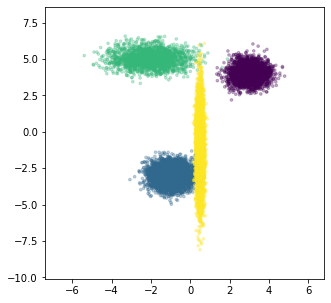

In [227]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:,0], data[:,1], alpha=0.3, s=7, c=data_label)
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax])
plt.show()

# Watershed Test

In [196]:
from scipy import stats

xgrid, ygrid = np.linspace(xmin,xmax,100), np.linspace(ymin,ymax,100)
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])

kernel = stats.gaussian_kde(dataset=data.T)
Z = np.reshape(kernel(positions).T, X.shape)

In [197]:
stat, xedge, yedge, binnumber = stats.binned_statistic_2d(data[:,0], data[:,1], None, 'count', bins=[xgrid, ygrid], expand_binnumbers=True)
binnumber

array([[74, 75, 74, ..., 55, 55, 55],
       [81, 73, 78, ..., 56, 48, 72]])

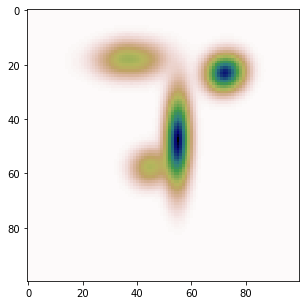

In [198]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
plt.show()

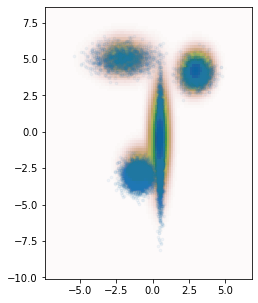

In [231]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
          extent=[xmin, xmax, ymin, ymax])
ax.scatter(data[:,0], data[:,1], alpha=0.05, s=7)
plt.show()

[[55 51]
 [72 76]
 [37 81]
 [45 41]]


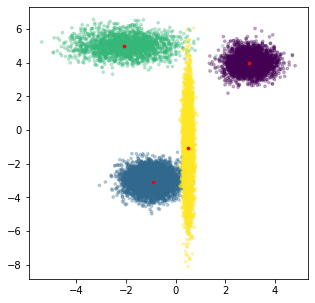

In [253]:
local_max_idx = peak_local_max(Z, min_distance=1)
print(local_max_idx)
local_max_bool = np.zeros(Z.shape, dtype=bool)
local_max_bool[tuple(local_max_idx.T)] = True

local_max_loc = np.vstack( (xgrid[local_max_idx[:,0]], ygrid[local_max_idx[:,1]]) ).T

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:,0], data[:,1], alpha=0.3, s=7, c=data_label)
plt.scatter(local_max_loc[:,0], local_max_loc[:,1], c='r', s=7)
plt.show()

In [248]:
local_max_idx = peak_local_max(Z, min_distance=1)
print(local_max_idx)
local_max_bool = np.zeros(Z.shape, dtype=bool)
local_max_bool[tuple(local_max_idx.T)] = True

[[55 51]
 [72 76]
 [37 81]
 [45 41]]


In [250]:
local_max_idx = peak_local_max(Z, min_distance=1, indices=True)
local_max_idx

/Users/donghur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  """Entry point for launching an IPython kernel.


array([[55, 51],
       [72, 76],
       [37, 81],
       [45, 41]])

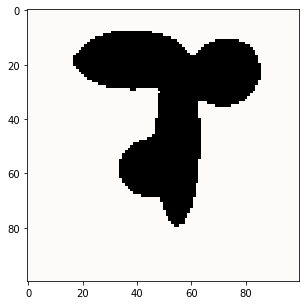

/Users/donghur/anaconda3/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


In [259]:
ROI_thresh = 0.001
mask = np.zeros(Z.shape)
mask[Z>ROI_thresh]=1

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(np.rot90(mask), cmap=plt.cm.gist_earth_r)
plt.show()

markers, _ = ndi.label(local_max_bool)
segmented = skimage.morphology.watershed(np.max(Z)-Z, markers, mask=mask)

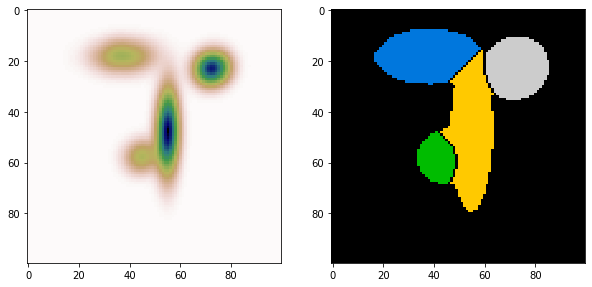

In [260]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
ax[1].imshow(np.rot90(segmented), cmap=plt.cm.nipy_spectral)
plt.show()

In [203]:
watershed_labels = segmented[binnumber[0,:], binnumber[1,:]]

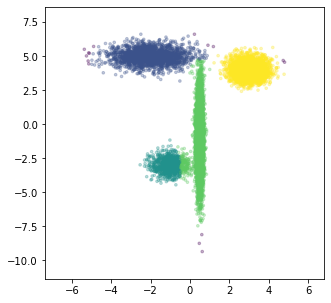

In [204]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(data[:,0], data[:,1], alpha=0.3, s=7, c=watershed_labels)
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax])
plt.show()

In [205]:
watershed_labels_mod = np.copy(watershed_labels)
watershed_labels_mod[watershed_labels_mod==0] = -1
watershed_labels_mod[watershed_labels_mod==1] = 2
watershed_labels_mod[watershed_labels_mod==2] = 1
watershed_labels_mod[watershed_labels_mod==3] = 3
watershed_labels_mod[watershed_labels_mod==4] = 0

In [206]:
label_mismatch, = np.where(data_label-watershed_labels_mod != 0)

num_mismatch = len(label_mismatch)
print(f"Accuracy: {round(100*(len(data_label)-num_mismatch)/len(data_label))}%")

Accuracy: 80%


# Watershed Function

In [262]:
import numpy as np
import skimage
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from scipy import stats

def Watershed(data, grid_dim=100, grid_padding=2, verbose=False, ROI_thresh=0.001, fig_alpha=0.2, fig_s=7, watershed_line=False):
    # data - [num_fr, 2]
    # grid_dim - number of bins for density and watershed
    # verbose - True creates figures
    # ROI_thresh - controls the area of interest. Lower number limits the area to denser regions
    # density grid
    xmin, ymin = data.min(axis=0)-grid_padding
    xmax, ymax = data.max(axis=0)+grid_padding

    print("Creating 2D Grid System...(1/7)")
    xgrid, ygrid = np.linspace(xmin,xmax,grid_dim), np.linspace(ymin,ymax,grid_dim)
    grid_dim_j = complex(grid_dim)
    X, Y = np.mgrid[xmin:xmax:grid_dim_j, ymin:ymax:grid_dim_j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    
    # compute gaussian kernel desnity
    print("Computing Gaussian Kernel...(2/7)")
    kernel = stats.gaussian_kde(dataset=data.T)
    Z = np.reshape(kernel(positions).T, X.shape)
    
    # find data pt's grid coordinate
    print("Finding Data Point Coordinates...(3/7)")
    stat, xedge, yedge, binnumber = stats.binned_statistic_2d(data[:,0], data[:,1], None, 'count', bins=[xgrid, ygrid], expand_binnumbers=True)
    
    if verbose:
        fig, ax = plt.subplots(2,3,figsize=(15,10))
        ax[0,0].scatter(data[:,0], data[:,1], alpha=fig_alpha, s=fig_s)
        ax[0,0].set(title="Data Points", xlabel="X Coord", ylabel="Y Coord")
        ax[0,1].imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
        ax[0,1].set(title="Gaussian KDE", xlabel="X Grid", ylabel="Y Grid")
    
    # find basin (local max)
    print("Finding Local Max Basin Point...(4/7)")
    local_max_idx = peak_local_max(Z, min_distance=1)
    local_max_bool = np.zeros(Z.shape, dtype=bool)
    local_max_bool[tuple(local_max_idx.T)] = True
    local_max_loc = np.vstack( (xgrid[local_max_idx[:,0]], ygrid[local_max_idx[:,1]]) ).T
    
    if verbose:
        ax[0,2].scatter(data[:,0], data[:,1], alpha=fig_alpha, s=fig_s)
        ax[0,2].scatter(local_max_loc[:,0], local_max_loc[:,1], c='r', s=7)
        ax[0,2].set(title="Basin Max Pts", xlabel="X Coord", ylabel="Y Coord")
    
    # create mask of ROI
    print("Creating Mask...(5/7)")
    mask = np.zeros(Z.shape)
    mask[Z>ROI_thresh]=1
    
    if verbose:
        ax[1,0].imshow(np.rot90(mask), cmap=plt.cm.gist_earth_r)
        ax[1,0].set(title="Mask", xlabel="X Grid", ylabel="Y Grid")
    
    # populate each basin region with corresponding marker label
    print("Finding Watershed...(6/7)")
    markers, _ = ndi.label(local_max_bool)
    segmented = skimage.segmentation.watershed(np.max(Z)-Z, markers, mask=mask, watershed_line=watershed_line)
    
    if verbose:
        ax[1,1].imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
        ax[1,1].imshow(np.rot90(segmented), cmap=plt.cm.nipy_spectral)
        ax[1,1].set(title="Watershed", xlabel="X Grid", ylabel="Y Grid")
    
    # create cluster label of data points
    print("Creating Watershed label...(7/7)")
    watershed_labels = segmented[binnumber[0,:], binnumber[1,:]]
    print("COMPLETE")
    
    if verbose:
        ax[1,2].scatter(data[:,0], data[:,1], alpha=fig_alpha, s=fig_s, c=watershed_labels)
        ax[1,2].set(xlim=[xmin, xmax], ylim=[ymin, ymax])
        ax[1,2].set(title="Watershed Labels", xlabel="X Coord", ylabel="Y Coord")
        plt.show()
    return watershed_labels

Creating 2D Grid System...(1/7)
Computing Gaussian Kernel...(2/7)
Finding Data Point Coordinates...(3/7)
Finding Local Max Basin Point...(4/7)
Creating Mask...(5/7)
Finding Watershed...(6/7)
Creating Watershed label...(7/7)
COMPLETE


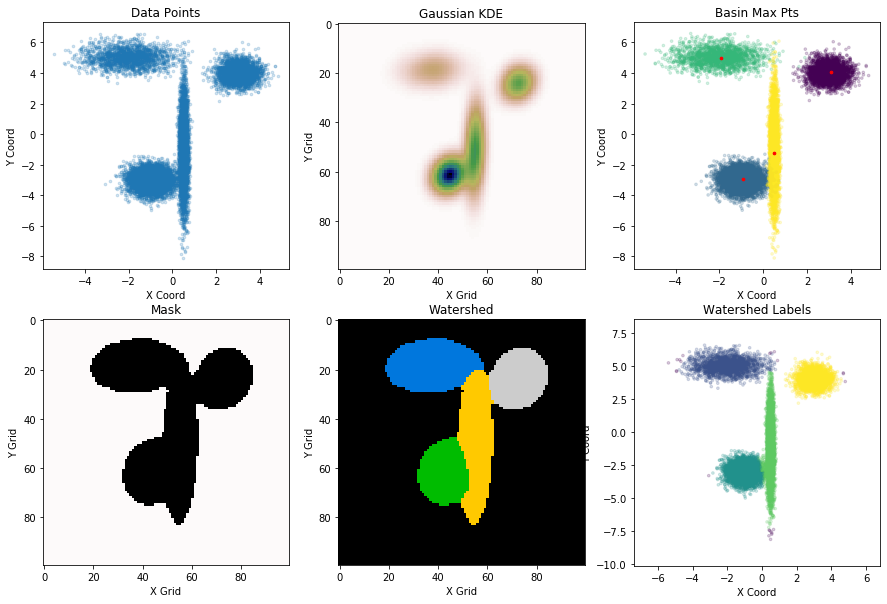

In [263]:
watershed_labels = Watershed(data=data, grid_dim=100, verbose=True)

In [258]:
watershed_labels_mod = np.copy(watershed_labels)
watershed_labels_mod[watershed_labels_mod==0] = -1
watershed_labels_mod[watershed_labels_mod==1] = 2
watershed_labels_mod[watershed_labels_mod==2] = 1
watershed_labels_mod[watershed_labels_mod==3] = 3
watershed_labels_mod[watershed_labels_mod==4] = 0

label_mismatch, = np.where(data_label-watershed_labels_mod != 0)

num_mismatch = len(label_mismatch)
print(f"Accuracy: {round(100*(len(data_label)-num_mismatch)/len(data_label))}%")

Accuracy: 86%
